Found 612 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8563 - loss: 0.1322 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


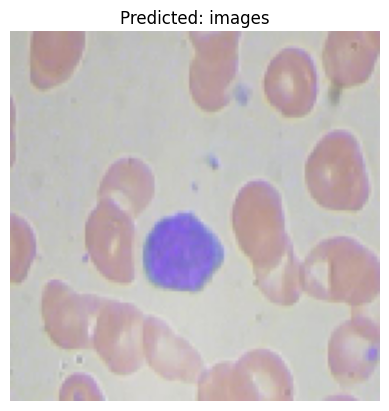

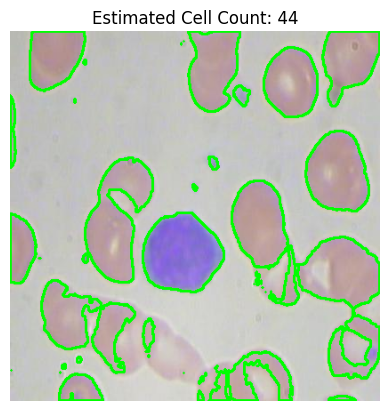

Estimated Blood Cell Count: 44
Health Status: Low Blood Cell Count - Possible anemia or infection risk ⚠️

🍽 Recommended Foods:
- Iron-rich foods: Spinach, red meat, lentils
- Vitamin B12: Eggs, dairy
- Vitamin C: Oranges, bell peppers

🚫 Foods to Avoid:
- Avoid processed foods & caffeine
- Minimize alcohol
- Limit high-calcium foods

💊 Recommended Medicines:
- Iron supplements (Ferrous sulfate, Ferrous gluconate)
- Vitamin B12 injections (for severe deficiency)
- Folic acid supplements


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Paths
train_dir = r'/content/drive/MyDrive/blood cell det/train'
valid_dir = r'/content/drive/MyDrive/blood cell det/valid'

# Data augmentation and preprocessing
data = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load dataset
train_data = data.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Get number of classes dynamically
num_classes = len(train_data.class_indices)

# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[early_stopping])

# Prediction on new image
image_path = r'/content/drive/MyDrive/blood cell det/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg'
image = load_img(image_path, target_size=(128, 128))
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

predicted_probs = model.predict(image_array)[0]
predicted_class_index = np.argmax(predicted_probs)
class_names = list(train_data.class_indices.keys())

plt.imshow(image)
plt.title(f'Predicted: {class_names[predicted_class_index]}')
plt.axis('off')
plt.show()

# Contour-based blood cell count
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cell_count = len(contours)

result_image = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 2)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

plt.imshow(result_image_rgb)
plt.title(f'Estimated Cell Count: {cell_count}')
plt.axis('off')
plt.show()

# Function to determine health status
def determine_health_status(cell_count):
    if cell_count < 100:
        return "Low Blood Cell Count - Possible anemia or infection risk ⚠️"
    elif 100 <= cell_count <= 300:
        return "Normal Blood Cell Count ✅"
    else:
        return "High Blood Cell Count - Possible infection or inflammation ⚠️"

# Function to suggest food
def suggest_food(health_status):
    if "Low" in health_status:
        return ["Iron-rich foods: Spinach, red meat, lentils", "Vitamin B12: Eggs, dairy", "Vitamin C: Oranges, bell peppers"]
    elif "Normal" in health_status:
        return ["Balanced diet: Fruits, vegetables, lean proteins", "Healthy fats: Nuts, seeds", "Hydration: Water, herbal teas"]
    elif "High" in health_status:
        return ["Anti-inflammatory foods: Blueberries, turmeric", "Fiber-rich foods: Oats, whole grains", "Antioxidants: Green tea, dark chocolate"]
    else:
        return ["No specific food recommendation available."]

# Function to avoid food
def avoid_food(health_status):
    if "Low" in health_status:
        return ["Avoid processed foods & caffeine", "Minimize alcohol", "Limit high-calcium foods"]
    elif "Normal" in health_status:
        return ["Limit processed sugars & junk food", "Avoid excessive red meat"]
    elif "High" in health_status:
        return ["Reduce high-sodium foods", "Limit fried foods & alcohol", "Minimize sugary drinks"]
    else:
        return ["No specific food restrictions available."]

# Function to recommend medicines
def recommend_medicine(health_status):
    if "Low" in health_status:
        return ["Iron supplements (Ferrous sulfate, Ferrous gluconate)", "Vitamin B12 injections (for severe deficiency)", "Folic acid supplements"]
    elif "Normal" in health_status:
        return ["No specific medication needed - maintain a balanced diet"]
    elif "High" in health_status:
        return ["Anti-inflammatory drugs (Ibuprofen, Naproxen)", "Antibiotics if infection is suspected", "Consult a doctor for further tests"]
    else:
        return ["No specific medicine recommendation available."]

# Get health status
health_status = determine_health_status(cell_count)

# Get food recommendations
food_recommendations = suggest_food(health_status)

# Get foods to avoid
foods_to_avoid = avoid_food(health_status)

# Get medicine recommendations
medicine_recommendations = recommend_medicine(health_status)

# Display results
print(f"Estimated Blood Cell Count: {cell_count}")
print(f"Health Status: {health_status}")

print("\n🍽 Recommended Foods:")
for food in food_recommendations:
    print(f"- {food}")

print("\n🚫 Foods to Avoid:")
for food in foods_to_avoid:
    print(f"- {food}")

print("\n💊 Recommended Medicines:")
for medicine in medicine_recommendations:
    print(f"- {medicine}")


In [ ]:
!pip install streamlit pyngrok



In [ ]:
import os
print(os.listdir())  # Check current directory


['.config', 'drive', 'sample_data']
